Moyennes France par niveau :
experience
EN    43600.0
MI    52100.0
SE    67500.0
Name: Salaire_Moyen_EUR, dtype: float64


,Ville,Niveau,Salaire_Net,Epargne
0,Paris,1. Junior,2107.333333,507.333333
2,Paris,2. Medium,2518.166667,418.166667
4,Paris,3. Senior,3262.500000,762.500000
1,San Francisco (US Avg),1. Junior,6105.946138,1605.946138
3,San Francisco (US Avg),2. Medium,8457.931409,3257.931409
5,San Francisco (US Avg),3. Senior,10032.800435,4032.800435


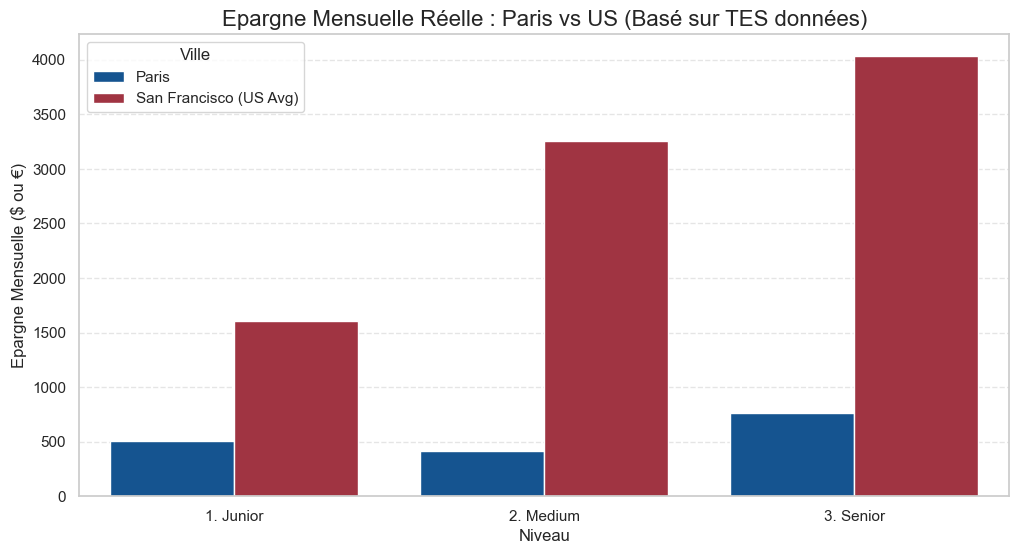

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# ÉTAPE 1 : RECUPERATION DES VRAIS SALAIRES (BRUT ANNUEL)
# ==============================================================================

# --- B. FRANCE (Source : Ton Dataset Manuel "df_fr_reel") ---
# LE FIX EST ICI : On utilise .groupby() pour fusionner Data Scientist + Data Engineer + etc.
# Comme ça, on a UNE SEULE moyenne par niveau d'expérience.

salaires_fr = df_fr_reel.groupby('experience')['Salaire_Moyen_EUR'].mean()

# Vérification (pour être sûr que tu n'as qu'un chiffre par niveau)
print("Moyennes France par niveau :")
print(salaires_fr)
# =====================================
# ÉTAPE 2 : CALCUL DU NET MENSUEL (APRES IMPOTS)
# ==============================================================================
# C'est là qu'on transforme le Brut Annuel en Net Mensuel dans la poche
# Hypothèses fiscales réalistes 2024 :
# - France : ~42% de charges/impôts total (Net = Brut * 0.58)
# - US (California) : ~32% de taxes Fed+State (Net = Brut * 0.68)

def get_net_mensuel(brut_annuel, pays):
    if pays == 'FR':
        return (brut_annuel * 0.58) / 12
    elif pays == 'US':
        return (brut_annuel * 0.68) / 12
    return 0

# ==============================================================================
# ÉTAPE 3 : COUT DE LA VIE (ESTIMATION 2024)
# ==============================================================================
# On définit le coût "Vie Tech" (Loyer centre + Bouffe + Sorties + Santé + Assurances)
# On adapte légèrement selon le niveau de vie (un Senior dépense plus qu'un Junior)

couts_vie = {
    'Paris': {'EN': 1600, 'MI': 2100, 'SE': 2500},  # Loyer ~1000-1500€
    'San Francisco': {'EN': 4500, 'MI': 5200, 'SE': 6000} # Loyer ~2500-3500$
}

# ==============================================================================
# ÉTAPE 4 : CONSTRUCTION DU TABLEAU FINAL
# ==============================================================================

data_comparatif = []
niveaux = ['EN', 'MI', 'SE']
labels_niveaux = {'EN': '1. Junior', 'MI': '2. Medium', 'SE': '3. Senior'}

for niv in niveaux:
    # --- PARIS ---
    brut_fr = salaires_fr.get(niv, 0) # Récupère ton chiffre Silkhom
    net_fr = get_net_mensuel(brut_fr, 'FR')
    cout_fr = couts_vie['Paris'][niv]
    epargne_fr = net_fr - cout_fr
    
    data_comparatif.append({
        'Ville': 'Paris', 
        'Niveau': labels_niveaux[niv], 
        'Salaire_Net': net_fr, 
        'Epargne': epargne_fr,
        'Source': 'Silkhom (Manuel)'
    })

    # --- US (San Francisco) ---
    brut_us = salaires_us.get(niv, 0) # Récupère ton chiffre Kaggle
    net_us = get_net_mensuel(brut_us, 'US')
    cout_us = couts_vie['San Francisco'][niv]
    epargne_us = net_us - cout_us
    
    data_comparatif.append({
        'Ville': 'San Francisco (US Avg)', 
        'Niveau': labels_niveaux[niv], 
        'Salaire_Net': net_us, 
        'Epargne': epargne_us,
        'Source': 'Kaggle (Big Data)'
    })

df_final_vrai = pd.DataFrame(data_comparatif)

# ==============================================================================
# ÉTAPE 5 : LE GRAPHIQUE DE VERITE
# ==============================================================================
plt.figure(figsize=(12, 6))

# On compare l'EPARGNE (Ce qui reste)
sns.barplot(
    data=df_final_vrai,
    x='Niveau',
    y='Epargne',
    hue='Ville',
    palette=['#0055A4', '#B22234'] # Bleu France vs Rouge US
)

plt.title("Epargne Mensuelle Réelle : Paris vs US (Basé sur TES données)", fontsize=16)
plt.ylabel("Epargne Mensuelle ($ ou €)")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Affichage des valeurs exactes
df_final_vrai[['Ville', 'Niveau', 'Salaire_Net', 'Epargne']].sort_values(['Ville', 'Niveau'])

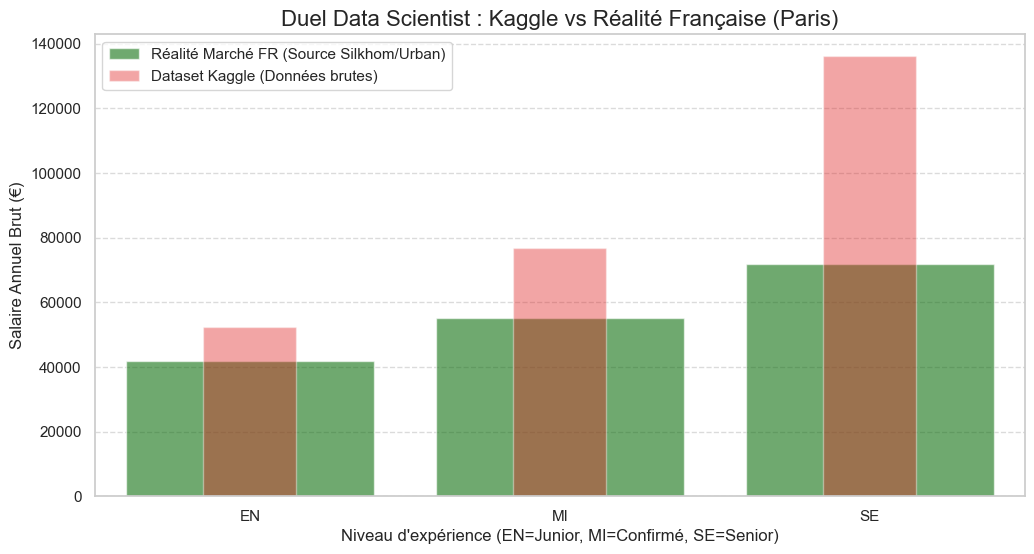

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# --- PARTIE 1 : La Réalité (Tes données manuelles) ---
# On filtre pour ne garder que les Data Scientists
df_reel_ds = df_fr_reel[df_fr_reel['metier'] == 'Data Scientist']

sns.barplot(
    data=df_reel_ds,
    x='experience',
    y='Salaire_Moyen_EUR',
    color='green',
    alpha=0.6,
    label='Réalité Marché FR (Source Silkhom/Urban)'
)

# --- PARTIE 2 : Kaggle (Le Dataset US/Mondial) ---
# On filtre Kaggle pour la France ET le job Data Scientist
df_kaggle_fr_ds = df_clean[
    (df_clean['company_location'] == 'FR') & 
    (df_clean['job_title'] == 'Data Scientist')
].copy()

# On convertit le salaire Kaggle (USD) en EUR pour comparer (1 USD = 0.95 EUR)
df_kaggle_fr_ds['Salaire_EUR'] = df_kaggle_fr_ds['Salaire_USD'] * 0.95

sns.barplot(
    data=df_kaggle_fr_ds,
    x='experience_level',
    y='Salaire_EUR',
    order=['EN', 'MI', 'SE'], # On force l'ordre Junior -> Senior
    color='red',
    alpha=0.4,
    width=0.3, # Barres plus fines
    errorbar=None,
    label='Dataset Kaggle (Données brutes)'
)

# --- FINITIONS ---
plt.title("Duel Data Scientist : Kaggle vs Réalité Française (Paris)", fontsize=16)
plt.ylabel("Salaire Annuel Brut (€)")
plt.xlabel("Niveau d'expérience (EN=Junior, MI=Confirmé, SE=Senior)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
# ⚠️ CORRECTION DES UNITÉS (k€ -> €)
# On multiplie par 1000 car tes chiffres sont en k€ (ex: 38 -> 38000)
df_fr_reel['min'] = df_fr_reel['min'] / 1000
df_fr_reel['max'] = df_fr_reel['max'] / 1000

# Recalcul des moyennes avec les bonnes unités
df_fr_reel['Salaire_Moyen_EUR'] = (df_fr_reel['min'] + df_fr_reel['max']) / 2

# Vérification : Tu dois voir des 42000, 50000, etc.
print("✅ Données réelles corrigées :")
df_fr_reel.head()

✅ Données réelles corrigées :


,metier,experience,ville,min,max,Salaire_Moyen_EUR,Salaire_Moyen_USD
0,Data Scientist,EN,Paris,38000.0,46000.0,42000.0,44100.0
1,Data Scientist,MI,Paris,48000.0,62000.0,55000.0,57750.0
2,Data Scientist,SE,Paris,64000.0,80000.0,72000.0,75600.0
3,Data Engineer,EN,Paris,42000.0,52000.0,47000.0,49350.0
4,Data Engineer,MI,Paris,53000.0,65000.0,59000.0,61950.0


In [19]:
import pandas as pd

# 1. On recrée les données de tes images manuellement
# J'ai mis les chiffres de ton image pour Paris.
# Tu devras ajouter les lignes pour "Data Engineer" ou "ML Engineer" si tu as les autres tableaux.

data_france_source = [
    # --- DATA SCIENTIST ---
    {'metier': 'Data Scientist', 'experience': 'EN', 'ville': 'Paris', 'min': 38, 'max': 46}, # Junior
    {'metier': 'Data Scientist', 'experience': 'MI', 'ville': 'Paris', 'min': 48, 'max': 62}, # Confirmé
    {'metier': 'Data Scientist', 'experience': 'SE', 'ville': 'Paris', 'min': 64, 'max': 80}, # Senior
    
    # --- Data Engineer --- 
    {'metier': 'Data Engineer', 'experience': 'EN', 'ville': 'Paris', 'min': 42, 'max': 52},
    {'metier': 'Data Engineer', 'experience': 'MI', 'ville': 'Paris', 'min': 53, 'max': 65},
    {'metier': 'Data Engineer', 'experience': 'SE', 'ville': 'Paris', 'min': 68, 'max': 85},

    # --- Data Analyst ---
    {'metier': 'Data Analyst', 'experience': 'EN', 'ville': 'Paris', 'min': 40, 'max': 48},
    {'metier': 'Data Analyst', 'experience': 'MI', 'ville': 'Paris', 'min': 48, 'max': 55},
    {'metier': 'Data Analyst', 'experience': 'SE', 'ville': 'Paris', 'min': 55, 'max': 70},

    # --- Ingenieur computer vision ---
    {'metier': 'Computer Vision Engineer', 'experience': 'EN', 'ville': 'Paris', 'min': 40, 'max': 45},
    {'metier': 'Computer Vision Engineer', 'experience': 'MI', 'ville': 'Paris', 'min': 42, 'max': 48},
    {'metier': 'Computer Vision Engineer', 'experience': 'SE', 'ville': 'Paris', 'min': 48, 'max': 70},

    # --- Ingenieur Deep Learning ---
    {'metier': 'Deep Learning Engineer', 'experience': 'EN', 'ville': 'Paris', 'min': 40, 'max': 45},
    {'metier': 'Deep Learning Engineer', 'experience': 'MI', 'ville': 'Paris', 'min': 45, 'max': 55},
    {'metier': 'Deep Learning Engineer', 'experience': 'SE', 'ville': 'Paris', 'min': 60, 'max': 75},

    # --- Ajoute ici les autres métiers si tu as les tableaux ---
    # {'metier': 'Data Engineer', 'experience': 'EN', 'ville': 'Paris', 'min': 40, 'max': 48},
]

# 2. On transforme en DataFrame
df_fr_reel = pd.DataFrame(data_france_source)

# 3. LE TRUC IMPORTANT : On calcule la moyenne de la fourchette
# Pour comparer avec Kaggle (qui a un seul chiffre), on prend le milieu (ex: entre 38 et 46 -> 42)
df_fr_reel['Salaire_Moyen_EUR'] = (df_fr_reel['min'] + df_fr_reel['max']) / 2

# 4. Conversion en USD (pour comparer avec Kaggle)
# Taux approximatif : 1 EUR = 1.05 USD
df_fr_reel['Salaire_Moyen_USD'] = df_fr_reel['Salaire_Moyen_EUR'] * 1.05

df_fr_reel

,metier,experience,ville,min,max,Salaire_Moyen_EUR,Salaire_Moyen_USD
0,Data Scientist,EN,Paris,38,46,42.0,44.100
1,Data Scientist,MI,Paris,48,62,55.0,57.750
2,Data Scientist,SE,Paris,64,80,72.0,75.600
3,Data Engineer,EN,Paris,42,52,47.0,49.350
4,Data Engineer,MI,Paris,53,65,59.0,61.950
5,Data Engineer,SE,Paris,68,85,76.5,80.325
6,Data Analyst,EN,Paris,40,48,44.0,46.200
7,Data Analyst,MI,Paris,48,55,51.5,54.075
8,Data Analyst,SE,Paris,55,70,62.5,65.625
9,Computer Vision Engineer,EN,Paris,40,45,42.5,44.625


In [17]:
# Compter le nombre de personnes par niveau en France
print(df_france['experience_level'].value_counts())

experience_level
SE    97
EN    92
MI    39
EX     2
Name: count, dtype: int64


🇫🇷 Nombre de postes analysés en France : 230


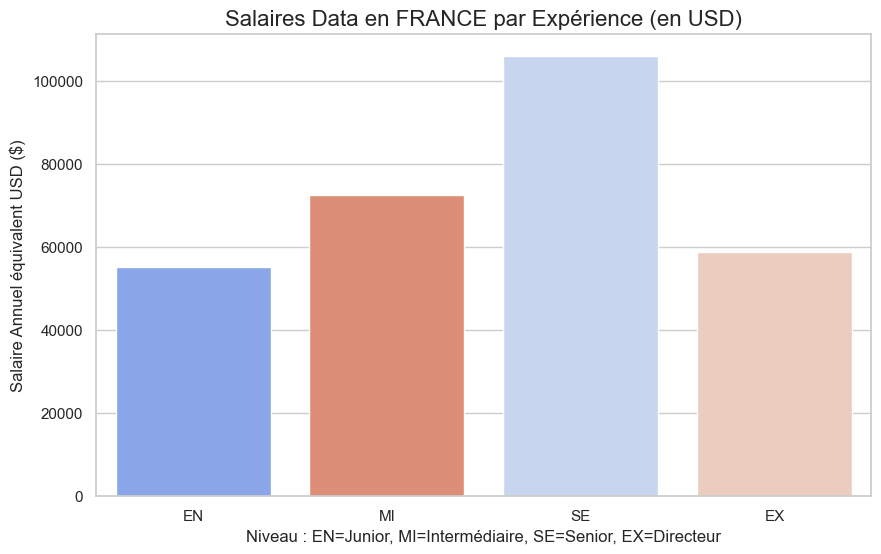


📊 SALAIRES MOYENS ESTIMÉS EN FRANCE (Brut Annuel) :
- EN : 52370 €
- MI : 68929 €
- SE : 100733 €
- EX : 55944 €


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. On isole la France
df_france = df_clean[df_clean['company_location'] == 'FR']

# Petit check de sécurité : Combien de lignes on a pour la France ?
print(f"🇫🇷 Nombre de postes analysés en France : {len(df_france)}")

# 2. Le Graphique Spécial France
plt.figure(figsize=(10, 6))

# Ordre logique : Junior -> Intermédiaire -> Senior -> Directeur
ordre_experience = ['EN', 'MI', 'SE', 'EX']

sns.barplot(
    data=df_france,
    x='experience_level',
    y='Salaire_USD',
    order=ordre_experience,
    estimator='mean',
    errorbar=None,
    palette="coolwarm", # Bleu-Blanc-Rouge (presque)
    hue='experience_level',
    legend=False
)

plt.title("Salaires Data en FRANCE par Expérience (en USD)", fontsize=16)
plt.ylabel("Salaire Annuel équivalent USD ($)")
plt.xlabel("Niveau : EN=Junior, MI=Intermédiaire, SE=Senior, EX=Directeur")
plt.show()

# 3. Les Chiffres Précis (Convertis en Euros pour toi)
# On prend un taux de change moyen actuel : 1 USD = 0.95 EUR
taux_change = 0.95 

moyennes_fr = df_france.groupby('experience_level')['Salaire_USD'].mean()

print("\n📊 SALAIRES MOYENS ESTIMÉS EN FRANCE (Brut Annuel) :")
for niveau in ordre_experience:
    if niveau in moyennes_fr:
        salaire_usd = moyennes_fr[niveau]
        salaire_eur = salaire_usd * taux_change
        print(f"- {niveau} : {salaire_eur:.0f} €")
    else:
        print(f"- {niveau} : Pas assez de données")

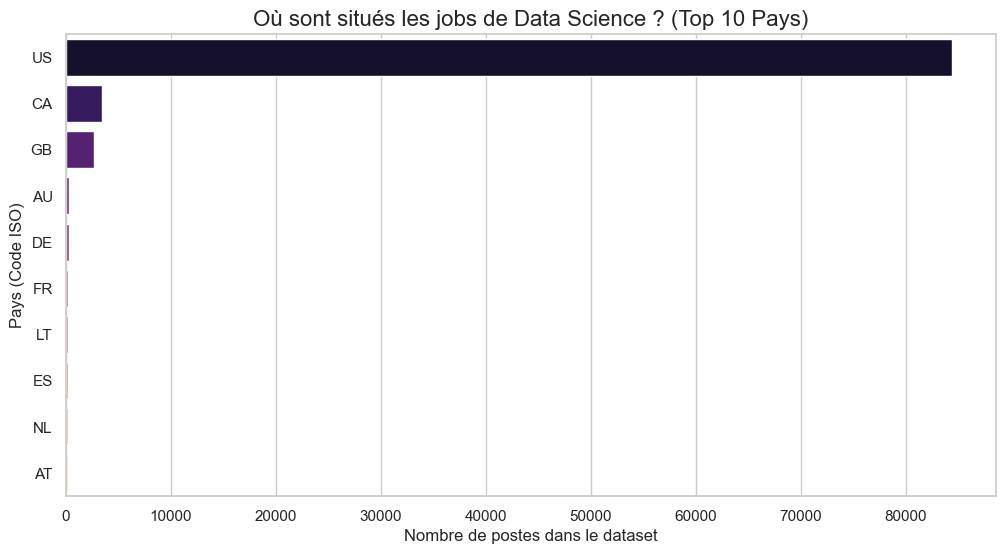

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# On prend les 10 premiers pays pour que le graphique reste lisible
top_10_pays = repartition_pays.head(10)

plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_10_pays.values,    # Le nombre de personnes (axe horizontal)
    y=top_10_pays.index,     # Les codes pays (axe vertical)
    hue=top_10_pays.index,   # (Pour éviter le warning de couleur)
    palette="magma",         # Une palette de couleurs "feu"
    legend=False
)

plt.title("Où sont situés les jobs de Data Science ? (Top 10 Pays)", fontsize=16)
plt.xlabel("Nombre de postes dans le dataset")
plt.ylabel("Pays (Code ISO)")
plt.show()

In [14]:
# Compter le nombre d'employés par pays (Localisation de l'entreprise)
repartition_pays = df['company_location'].value_counts()

# Afficher le Top 10
print("🌍 Top 10 des pays avec le plus de jobs Data :")
print(repartition_pays.head(10))

🌍 Top 10 des pays avec le plus de jobs Data :
company_location
US    84347
CA     3416
GB     2670
AU      317
DE      282
FR      230
LT      214
ES      207
NL      193
AT      191
Name: count, dtype: int64


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Feature Engineering : On doit transformer le texte (EN, MI...) en chiffres (Années)
# On fait une estimation : Junior=1 an, Mid=3 ans, Senior=5 ans, Executive=10 ans
mapping_exp = {'EN': 1, 'MI': 3, 'SE': 5, 'EX': 10}

# On crée une nouvelle colonne numérique
df_clean['years_exp'] = df_clean['experience_level'].map(mapping_exp)

# 2. Préparation des données (X = Les critères, y = La cible)
X = df_clean[['years_exp']]  # Double crochets car X doit être un tableau 2D
y = df_clean['Salaire_USD']

# 3. Création et Entraînement du modèle (L'IA apprend)
model = LinearRegression()
model.fit(X, y)

# 4. Prédiction (La boule de cristal) CORRIGÉE
annee_a_predire = 7

# On crée un petit DataFrame pour la prédiction, comme ça le modèle retrouve ses petits
X_pred = pd.DataFrame([[annee_a_predire]], columns=['years_exp'])

prediction = model.predict(X_pred)

print(f"💰 Prédiction de l'IA pour {annee_a_predire} ans d'expérience : {prediction[0]:.2f} $")
print(f"📈 Augmentation moyenne par année d'expérience : +{model.coef_[0]:.2f} $")

💰 Prédiction de l'IA pour 7 ans d'expérience : 198208.73 $
📈 Augmentation moyenne par année d'expérience : +14144.88 $


C:\Users\adami\AppData\Local\Temp\ipykernel_3636\4277315026.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


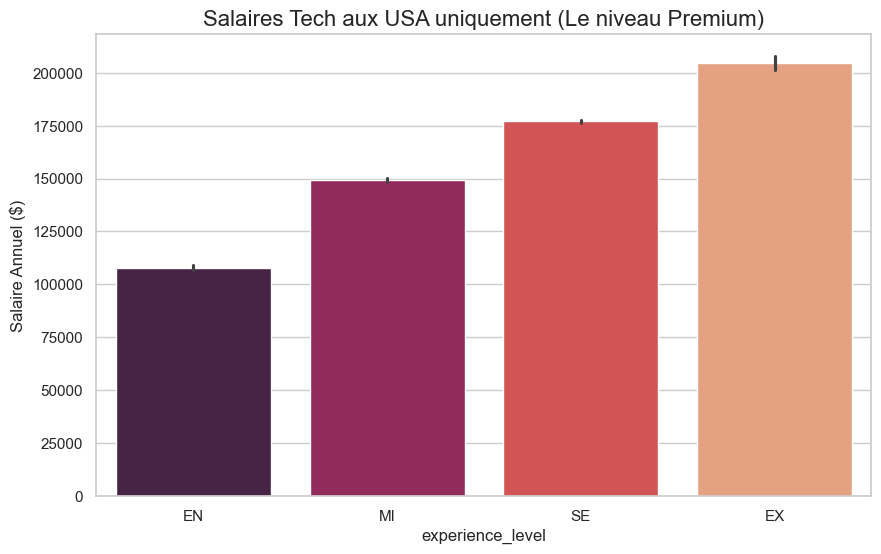

Salaire moyen d'un Senior aux USA : 177049 $


In [9]:
# On filtre : Que les jobs aux USA ('US')
df_us = df_clean[df_clean['company_location'] == 'US']

# On refait le graphique juste pour les USA
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_us,
    x='experience_level',
    y='Salaire_USD',
    order=['EN', 'MI', 'SE', 'EX'],
    estimator='mean',
    palette="rocket" # Une autre couleur pour changer
)
plt.title("Salaires Tech aux USA uniquement (Le niveau Premium)", fontsize=16)
plt.ylabel("Salaire Annuel ($)")
plt.show()

# On affiche le chiffre exact pour un Senior (SE) aux USA
moyenne_senior_us = df_us[df_us['experience_level'] == 'SE']['Salaire_USD'].mean()
print(f"Salaire moyen d'un Senior aux USA : {moyenne_senior_us:.0f} $")

In [8]:
# Calcul de la moyenne exacte par niveau
salaire_moyen = df_clean.groupby('experience_level')['Salaire_USD'].mean().sort_values()

print(salaire_moyen)

experience_level
EN    100059.640750
MI    143045.893355
SE    172768.485259
EX    200875.546612
Name: Salaire_USD, dtype: float64


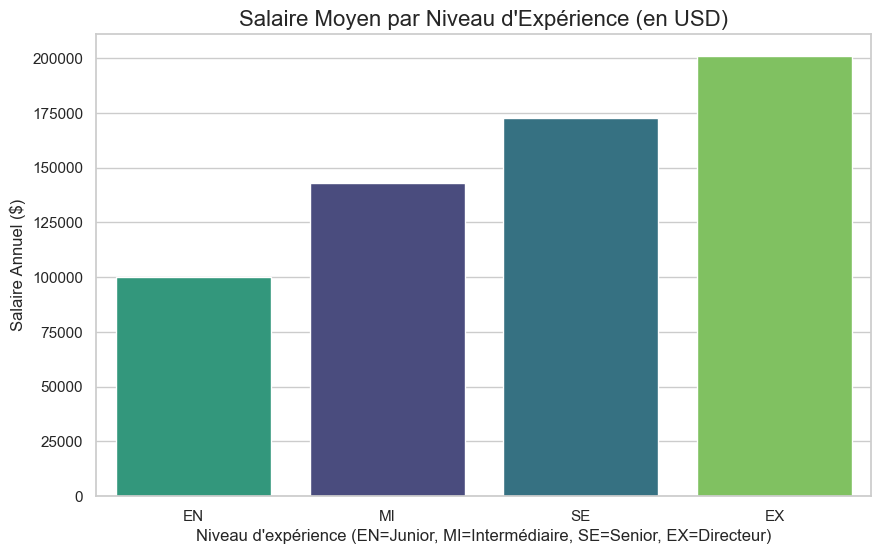

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuration du style (pour que ce soit joli)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 2. Le calcul : Salaire moyen par niveau d'expérience
# On trie l'ordre logiquement : Entry -> Mid -> Senior -> Executive
ordre_experience = ['EN', 'MI', 'SE', 'EX']

# 3. Le graphique (Barplot)
sns.barplot(
    data=df_clean,
    x='experience_level',
    y='Salaire_USD',
    order=ordre_experience,
    estimator='mean', # On affiche la MOYENNE
    errorbar=None,     # On enlève les petites barres d'erreur pour que ce soit propre
    palette="viridis" ,# Une couleur moderne
    hue='experience_level', # <--- L'ajout magique
    legend=False            # <--- On cache la légende car inutile ici
)





# 4. Les titres
plt.title("Salaire Moyen par Niveau d'Expérience (en USD)", fontsize=16)
plt.xlabel("Niveau d'expérience (EN=Junior, MI=Intermédiaire, SE=Senior, EX=Directeur)")
plt.ylabel("Salaire Annuel ($)")
plt.show()

In [ ]:
# On sélectionne uniquement les colonnes stratégiques
colonnes_utiles = [
  
  

df_clean = df[colonnes_utiles].copy()

# On renomme la colonne salaire pour que ce soit plus clair
df_clean = df_clean.rename(columns={'salary_in_usd': 'Salaire_USD'})

# Vérification
df_clean.head()

,work_year,experience_level,employment_type,job_title,Salaire_USD,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Research Scientist,208000,US,0,US,M
1,2025,MI,FT,Research Scientist,147000,US,0,US,M
2,2025,SE,FT,Research Scientist,173000,US,0,US,M
3,2025,SE,FT,Research Scientist,117000,US,0,US,M
4,2025,MI,FT,AI Engineer,100000,US,100,US,M


In [ ]:
# Affiche le Top 20 des métiers les plus fréquents 
df['job_title'].value_counts().head(20)

job_title
Data Scientist                    13848
Data Engineer                     11323
Software Engineer                 10133
Data Analyst                       9081
Machine Learning Engineer          6643
Engineer                           5804
Manager                            3832
Research Scientist                 2641
Analyst                            2314
Applied Scientist                  1816
Data Architect                     1557
Analytics Engineer                 1424
Product Manager                    1394
Associate                          1271
Research Engineer                  1249
AI Engineer                         936
Data Manager                        761
Business Intelligence Engineer      702
Machine Learning Researcher         669
Consultant                          657
Name: count, dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93597 entries, 0 to 93596
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           93597 non-null  int64 
 1   experience_level    93597 non-null  object
 2   employment_type     93597 non-null  object
 3   job_title           93597 non-null  object
 4   salary              93597 non-null  int64 
 5   salary_currency     93597 non-null  object
 6   salary_in_usd       93597 non-null  int64 
 7   employee_residence  93597 non-null  object
 8   remote_ratio        93597 non-null  int64 
 9   company_location    93597 non-null  object
 10  company_size        93597 non-null  object
dtypes: int64(4), object(7)
memory usage: 7.9+ MB


In [ ]:
import pandas as pd

# Chargement du fichier
df = pd.read_csv('salaries.csv')


df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Research Scientist,208000,USD,208000,US,0,US,M
1,2025,MI,FT,Research Scientist,147000,USD,147000,US,0,US,M
2,2025,SE,FT,Research Scientist,173000,USD,173000,US,0,US,M
3,2025,SE,FT,Research Scientist,117000,USD,117000,US,0,US,M
4,2025,MI,FT,AI Engineer,100000,USD,100000,US,100,US,M
